In [1]:
import ruamel.yaml as yaml
import os
import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    # try to load config file
    try:
        with open("config.yaml", 'r') as stream:
            cfg = yaml.safe_load(stream)
    # If not found move back one directory level
    except FileNotFoundError:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)

# Add directory to PATH
path = os.getcwd()

if path not in sys.path:
    sys.path.append(path)


## Load and Process Data

In [2]:
df = pd.read_csv('data/processed/modelling_data_dropped_null_wins.csv')

## Fit Model

In [3]:
df.head()

,Season_2014-15,Season_2015-16,Season_2016-17,Season_2017-18,Day_Of_WeekFri,Day_Of_WeekMon,Day_Of_WeekSat,Day_Of_WeekSun,Day_Of_WeekThu,Day_Of_WeekTue,...,player8_WINS,player8_RPM,player8_DRPM,player8_ORPM,player8_WINS_portion,player8_RPM_portion,Tot_WINS,Tot_RPM,Ticket_Value,TV_Rate
0,0,0,1,0,0,0,0,0,1,0,...,2.67,-0.60,-0.46,-0.14,0.000927,-0.000208,0.004895,-0.000510,0.671432,5.288334
1,0,0,1,0,0,0,0,0,1,0,...,0.05,-3.02,-0.06,-2.96,0.000016,-0.000968,0.006687,-0.008436,0.697920,5.698246
2,0,0,1,0,1,0,0,0,0,0,...,4.06,0.13,-1.23,1.36,0.001208,0.000039,0.005304,-0.000855,0.725555,4.477193
3,0,0,1,0,1,0,0,0,0,0,...,0.98,-0.26,0.13,-0.39,0.000204,-0.000054,0.006790,-0.011398,0.463623,3.068853
4,0,0,1,0,1,0,0,0,0,0,...,2.40,-0.68,-1.24,0.56,0.000833,-0.000236,0.006875,-0.001303,0.759319,4.683684


In [72]:
X = df.drop(columns=['Ticket_Value', 'TV_Rate'])
Y_Tickets = df['Ticket_Value']
Y_TV = df['TV_Rate']

In [73]:
best_params_tickets = {'subsample': 0.35000000000000003,
 'n_estimators': 5,
 'min_samples_split': 11,
 'min_samples_leaf': 5,
 'max_features': 0.9000000000000001,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.001,
 'alpha': 0.95}

best_params_TV = {'subsample': 0.8500000000000001,
 'n_estimators': 5,
 'min_samples_split': 16,
 'min_samples_leaf': 11,
 'max_features': 0.45,
 'max_depth': 6,
 'loss': 'huber',
 'learning_rate': 0.5,
 'alpha': 0.85}

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline
gbr_tv = GradientBoostingRegressor(**best_params_TV)
gbr_tickets = GradientBoostingRegressor(**best_params_tickets)

In [41]:
%%time
gbr_tv.fit(X, Y_TV)
gbr_tickets.fit(X, Y_Tickets)

Wall time: 985 ms


## Plot Partial Dependence

In [54]:
pdp_fig_TV, tv_axes = partial_dependence(gbr_tv, Y_TV.values, grid=X['superteam_flg'].values.reshape(1,-1), percentiles=(0,1))
pdp_fig_Tickets, tickets_axes = partial_dependence(gbr_tickets, Y_Tickets.values, grid=X['superteam_flg'].values.reshape(1,-1), percentiles=(0,1))


In [57]:
tickets_axes

## Using plot_partial_dependence function

C:\Users\afurrier\AppData\Local\Continuum\miniconda3\envs\hackathon\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.8583119524774302, top=0.8583119524774302
  'bottom=%s, top=%s') % (bottom, top))


AttributeError: 'list' object has no attribute 'set_label'

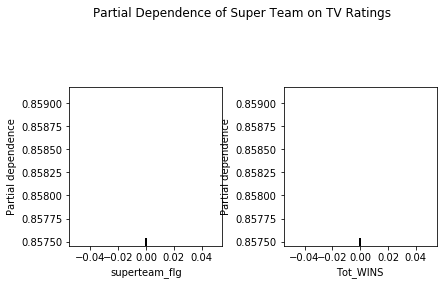

In [69]:
pdp_fig_TV, tv_axes = plot_partial_dependence(gbr_tv, X, features=['superteam_flg', 'Tot_WINS'], feature_names=['superteam_flg', 'Tot_WINS'],
                                              n_cols=2,
                                              percentiles=(0.0, 1.),
                                              grid_resolution=500,
                                             )
pdp_fig_TV.suptitle('Partial Dependence of Super Team on TV Ratings')
tv_axes.set_label('Super Team')
tv_axes.set_label('TV Rating Prediction')
tv_axes.ylim(0, 1)
tv_axes.xlim(-1, 2)

C:\Users\afurrier\AppData\Local\Continuum\miniconda3\envs\hackathon\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.8583119524774302, top=0.8583119524774302
  'bottom=%s, top=%s') % (bottom, top))


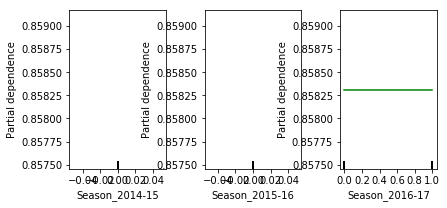

In [77]:
feat_nums = [0,1,2]
feats=['superteam_flg']
feat_names=['Super Team Y/N']
pdp_fig_TV, tv_axes = plot_partial_dependence(gbr_tv, X, feat_nums, feature_names=X.iloc[:, feat_nums].columns.values.tolist(),
                                             )

C:\Users\afurrier\AppData\Local\Continuum\miniconda3\envs\hackathon\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.8583119524774302, top=0.8583119524774302
  'bottom=%s, top=%s') % (bottom, top))


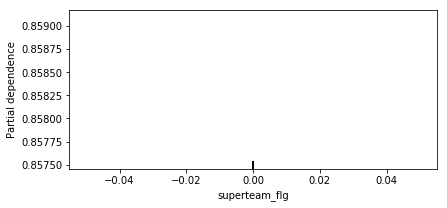

In [80]:
pdp_fig_TV, tv_axes = plot_partial_dependence(gbr_tv, X, features=feats, feature_names=feats
                                             )

## Create PDP manually

Xaxis is val -- > 0 or 1
Y is output prediction

1) Make predictions with Avg Prediction (take mean columnwise)

2) Make Prediction when Superteam ==0, and when it ==1

3) Plot these two rows

In [99]:
avg_pred = pd.DataFrame(X.mean()).T
superteam_absent = avg_pred.assign(superteam_flg = 0)
superteam_present = avg_pred.assign(superteam_flg = 1)
pdp_predictions = pd.concat([superteam_absent, superteam_present])
pdp_predictions.index = ['Superteam_Absent', 'Superteam_Present']

In [100]:
pdp_predictions['TV_Rating_Predictions'] = gbr_tv.predict(pdp_predictions)
pdp_predictions['Ticket_Value_Predictions'] = gbr_tickets.predict(pdp_predictions.drop(columns='TV_Rating_Predictions'))

In [101]:
import altair as alt

ModuleNotFoundError: No module named 'altair'

In [44]:
plt.show(

TypeError: show() got an unexpected keyword argument 'fig'